Initializing the dataset

In [ ]:
!pip install -U gdown

In [ ]:
from google.colab import drive
drive.mount('/content/drive')


Mounted at /content/drive


Fetching some sample images

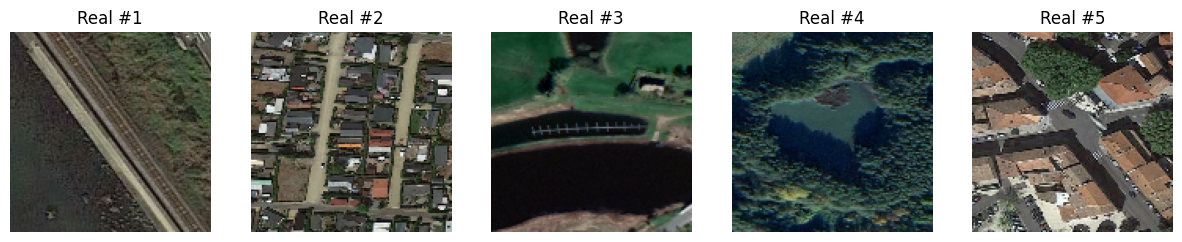

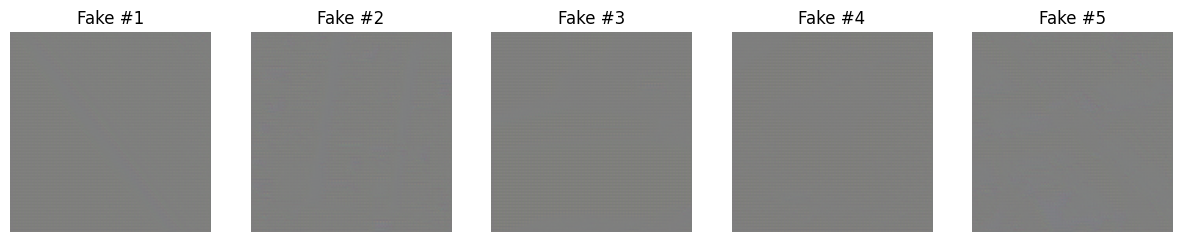

In [ ]:
0import os
import cv2
import matplotlib.pyplot as plt

# Updated base paths (don't go directly to 0000 folders)
real_base = '/content/drive/MyDrive/DM-AER-DeepFake-V1-sample/DM-AER-DeepFake-V1-sample/validation/REAL/Million-AED'
fake_base = '/content/drive/MyDrive/DM-AER-DeepFake-V1-sample/DM-AER-DeepFake-V1-sample/validation/FAKE/StyleGAN2-AED-V1-800K'

# Helper function to gather image paths from subfolders
def collect_image_paths(base_folder, limit=50):
    image_paths = []
    for root, _, files in os.walk(base_folder):
        for file in sorted(files):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
            if len(image_paths) >= limit:
                return image_paths
    return image_paths

# Collect 50 images from each folder
real_image_paths = collect_image_paths(real_base, limit=50)
fake_image_paths = collect_image_paths(fake_base, limit=50)

# Load and resize images
def load_images(image_paths, resize_to=(128, 128)):
    images = []
    for path in image_paths:
        img = cv2.imread(path)
        if img is not None:
            img = cv2.resize(img, resize_to)
            img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
            images.append(img)
        else:
            print(f"⚠️ Failed to load image: {path}")
    return images

real_imgs = load_images(real_image_paths)
fake_imgs = load_images(fake_image_paths)

# Show images
def show_samples(images, title, n=5):
    n = min(n, len(images))
    if n == 0:
        print(f"No images found for {title}")
        return
    plt.figure(figsize=(15, 3))
    for i in range(n):
        plt.subplot(1, n, i + 1)
        plt.imshow(images[i])
        plt.title(f"{title} #{i + 1}")
        plt.axis('off')
    plt.show()

# Plot
show_samples(real_imgs, "Real")
show_samples(fake_imgs, "Fake")

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
def count_images(base_folder):
    count = 0
    for root, _, files in os.walk(base_folder):
        for file in files:
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                count += 1
    return count

# Count images
real_count = count_images(real_base)
fake_count = count_images(fake_base)

print(f"📷 Total REAL images: {real_count}")
print(f"🧠 Total FAKE images: {fake_count}")

📷 Total REAL images: 1000
🧠 Total FAKE images: 1005


Data Preprocessing -> Loading and normalizing the size of the images

In [ ]:
import os
import cv2
import numpy as np
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader
import torch
import torchvision.transforms as transforms
from PIL import Image

# -------------------------------
# 1. Paths
# -------------------------------
real_base = '/content/drive/MyDrive/DM-AER-DeepFake-V1-sample/DM-AER-DeepFake-V1-sample/validation/REAL/Million-AED'
fake_base = '/content/drive/MyDrive/DM-AER-DeepFake-V1-sample/DM-AER-DeepFake-V1-sample/validation/FAKE/StyleGAN2-AED-V1-800K'

IMG_SIZE = 224  # ✅ Fixed: ViT-small pretrained requires 224x224

# -------------------------------
# 2. Collect image paths
# -------------------------------
def collect_paths(folder, label):
    paths = []
    for root, _, files in os.walk(folder):
        for f in files:
            if f.lower().endswith(('.jpg', '.jpeg', '.png')):
                paths.append((os.path.join(root, f), label))
    return paths

real_paths = collect_paths(real_base, 0)   # label 0 = REAL
fake_paths = collect_paths(fake_base, 1)   # label 1 = FAKE

all_data = real_paths + fake_paths
print(f"✅ Found {len(real_paths)} REAL and {len(fake_paths)} FAKE images")

# -------------------------------
# 3. Train/Val/Test Split
# -------------------------------
train_data, test_data = train_test_split(
    all_data, test_size=0.15, random_state=42, stratify=[l for _, l in all_data]
)
train_data, val_data  = train_test_split(
    train_data, test_size=0.15, random_state=42, stratify=[l for _, l in train_data]
)

print(f"📊 Train: {len(train_data)}, Val: {len(val_data)}, Test: {len(test_data)}")

# -------------------------------
# 4. Torch Dataset
# -------------------------------
transform = transforms.Compose([
    transforms.Resize((IMG_SIZE, IMG_SIZE)),   # ✅ Fixed: 224x224
    transforms.ToTensor(),                     # [0,1]
    transforms.Normalize([0.5, 0.5, 0.5],      # ✅ Fixed: 3 channels
                         [0.5, 0.5, 0.5])      # Normalize to [-1,1]
])

class RealFakeDataset(Dataset):
    def __init__(self, data_list, transform=None):
        self.data_list = data_list
        self.transform = transform

    def __len__(self):
        return len(self.data_list)

    def __getitem__(self, idx):
        img_path, label = self.data_list[idx]
        image = Image.open(img_path).convert("RGB")
        if self.transform:
            image = self.transform(image)
        return image, torch.tensor(label, dtype=torch.long)

# -------------------------------
# 5. DataLoaders
# -------------------------------
BATCH_SIZE = 32

train_dataset = RealFakeDataset(train_data, transform=transform)
val_dataset   = RealFakeDataset(val_data, transform=transform)
test_dataset  = RealFakeDataset(test_data, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True, num_workers=2)
val_loader   = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)
test_loader  = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False, num_workers=2)

print("✅ DataLoaders ready!")


✅ Found 1000 REAL and 1005 FAKE images
📊 Train: 1448, Val: 256, Test: 301
✅ DataLoaders ready!


Build and train the VIT-Small model

In [ ]:
# =============================
# Install dependencies
# =============================
!pip install torchmetrics timm -q

import torch
import torch.nn as nn
import torch.optim as optim
from torchmetrics.classification import Accuracy
from tqdm import tqdm
import timm

# =============================
# Define the ViT-Small Model
# =============================
class ViT_Small_Classifier(nn.Module):
    def __init__(self, num_classes=2):
        super(ViT_Small_Classifier, self).__init__()
        # Use timm's ViT Small pretrained on ImageNet
        self.vit = timm.create_model("vit_small_patch16_224", pretrained=True, num_classes=num_classes)

    def forward(self, x):
        return self.vit(x)

# =============================
# Setup
# =============================
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ViT_Small_Classifier(num_classes=2).to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.AdamW(model.parameters(), lr=3e-5, weight_decay=0.01)

train_acc = Accuracy(task="multiclass", num_classes=2).to(device)
val_acc   = Accuracy(task="multiclass", num_classes=2).to(device)

# =============================
# Training Loop
# =============================
def train_model(model, train_loader, val_loader, epochs=15):
    best_val_acc = 0.0

    for epoch in range(epochs):
        # ---- Training ----
        model.train()
        train_loss = 0.0

        loop = tqdm(train_loader, leave=False)
        for images, labels in loop:
            images, labels = images.to(device), labels.to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, labels)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            train_acc.update(outputs, labels)

            loop.set_description(f"Epoch [{epoch+1}/{epochs}]")
            loop.set_postfix(loss=loss.item())

        avg_train_loss = train_loss / len(train_loader)
        avg_train_acc  = train_acc.compute().item()
        train_acc.reset()

        # ---- Validation ----
        model.eval()
        val_loss = 0.0
        with torch.no_grad():
            for images, labels in val_loader:
                images, labels = images.to(device), labels.to(device)
                outputs = model(images)
                loss = criterion(outputs, labels)
                val_loss += loss.item()
                val_acc.update(outputs, labels)

        avg_val_loss = val_loss / len(val_loader)
        avg_val_acc  = val_acc.compute().item()
        val_acc.reset()

        # Print results
        print(f"Epoch [{epoch+1}/{epochs}] "
              f"Train Loss: {avg_train_loss:.4f}, Train Acc: {avg_train_acc:.4f} "
              f"| Val Loss: {avg_val_loss:.4f}, Val Acc: {avg_val_acc:.4f}")

        # Save best model
        if avg_val_acc > best_val_acc:
            best_val_acc = avg_val_acc
            torch.save(model.state_dict(), "best_vit_small_model.pth")

    print("✅ Training Done! Best Val Acc:", best_val_acc)

# =============================
# Run Training
# =============================
train_model(model, train_loader, val_loader, epochs=15)

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 983.2/983.2 kB 23.3 MB/s eta 0:00:00


/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


model.safetensors:   0%|          | 0.00/88.2M [00:00<?, ?B/s]

Epoch [1/15] Train Loss: 0.3582, Train Acc: 0.8204 | Val Loss: 0.0856, Val Acc: 0.9727


Epoch [2/15] Train Loss: 0.0232, Train Acc: 0.9972 | Val Loss: 0.0369, Val Acc: 0.9883


Epoch [3/15] Train Loss: 0.0035, Train Acc: 1.0000 | Val Loss: 0.0242, Val Acc: 0.9883


Epoch [4/15] Train Loss: 0.0014, Train Acc: 1.0000 | Val Loss: 0.0213, Val Acc: 0.9961


Epoch [5/15] Train Loss: 0.0009, Train Acc: 1.0000 | Val Loss: 0.0179, Val Acc: 0.9961


Epoch [6/15] Train Loss: 0.0006, Train Acc: 1.0000 | Val Loss: 0.0179, Val Acc: 0.9961


Epoch [7/15] Train Loss: 0.0004, Train Acc: 1.0000 | Val Loss: 0.0169, Val Acc: 0.9961


Epoch [8/15] Train Loss: 0.0003, Train Acc: 1.0000 | Val Loss: 0.0163, Val Acc: 0.9961


Epoch [9/15] Train Loss: 0.0003, Train Acc: 1.0000 | Val Loss: 0.0166, Val Acc: 0.9961


Epoch [10/15] Train Loss: 0.0002, Train Acc: 1.0000 | Val Loss: 0.0158, Val Acc: 0.9961


Epoch [11/15] Train Loss: 0.0002, Train Acc: 1.0000 | Val Loss: 0.0156, Val Acc: 0.9961


Epoch [12/15] Train Loss: 0.0002, Train Acc: 1.0000 | Val Loss: 0.0150, Val Acc: 0.9961


Epoch [13/15] Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0154, Val Acc: 0.9961


Epoch [14/15] Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0151, Val Acc: 0.9961


Epoch [15/15] Train Loss: 0.0001, Train Acc: 1.0000 | Val Loss: 0.0151, Val Acc: 0.9961
✅ Training Done! Best Val Acc: 0.99609375


Evaluation the test data and the confusion matrix generation

Classification Report:
               precision    recall  f1-score   support

        REAL       1.00      0.99      1.00       150
        FAKE       0.99      1.00      1.00       151

    accuracy                           1.00       301
   macro avg       1.00      1.00      1.00       301
weighted avg       1.00      1.00      1.00       301



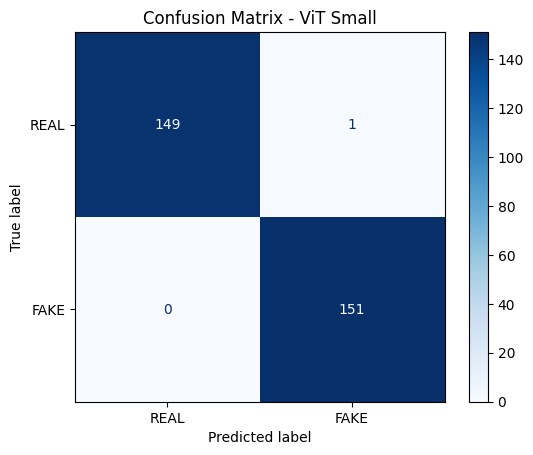

In [ ]:
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

# --- Evaluation Function ---
def evaluate_model(model, test_loader, device):
    model.eval()
    all_preds = []
    all_labels = []

    with torch.no_grad():
        for images, labels in test_loader:
            images, labels = images.to(device), labels.to(device)

            outputs = model(images)
            preds = torch.argmax(outputs, dim=1)

            all_preds.extend(preds.cpu().numpy())
            all_labels.extend(labels.cpu().numpy())

    return np.array(all_labels), np.array(all_preds)


# --- Run Evaluation ---
y_true, y_pred = evaluate_model(model, test_loader, device)

# --- Classification Report ---
print("Classification Report:\n", classification_report(y_true, y_pred, target_names=['REAL', 'FAKE']))

# --- Confusion Matrix ---
cm = confusion_matrix(y_true, y_pred)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=['REAL', 'FAKE'])
disp.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix - ViT Small")
plt.show()


In [ ]:
# Quick check: print predicted vs true for one val batch
model.eval()
import numpy as np
with torch.no_grad():
    for images, labels in val_loader:
        images = images.to(device)
        outputs = model(images)
        preds = torch.argmax(outputs, dim=1).cpu().numpy()
        labels_np = labels.cpu().numpy()
        print("true  :", labels_np[:20])
        print("preds :", preds[:20])
        break
import torch
import torch.nn as nn
from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import numpy as np

true  : [0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1]
preds : [0 0 0 0 0 0 1 1 1 0 1 1 0 1 0 1 0 1 0 1]


In [ ]:
# Evaluate on full test set and check if inversion improves accuracy
y_true = []
y_pred = []

model.eval()
with torch.no_grad():
    for images, labels in test_loader:
        images = images.to(device)
        outs = model(images)
        preds = torch.argmax(outs, dim=1).cpu().numpy()
        y_pred.extend(preds)
        y_true.extend(labels.cpu().numpy())

import numpy as np
y_true = np.array(y_true)
y_pred = np.array(y_pred)

acc_raw = (y_pred == y_true).mean()
acc_inverted = ((1 - y_pred) == y_true).mean()

print(f"Accuracy (raw): {acc_raw:.4f}")
print(f"Accuracy (inverted predictions): {acc_inverted:.4f}")

if acc_inverted > acc_raw:
    print(">>> Detected: predictions are inverted. We'll invert mapping at inference.")
    INVERT_PRED = True
else:
    print(">>> Predictions align with labels. No inversion needed.")
    INVERT_PRED = False


Accuracy (raw): 0.9967
Accuracy (inverted predictions): 0.0033
>>> Predictions align with labels. No inversion needed.


Upload the image and check

In [ ]:
from google.colab import files
from PIL import Image
import torch
import torchvision.transforms as transforms

# Upload image
uploaded = files.upload()

# Load the first uploaded image
img_path = list(uploaded.keys())[0]
image = Image.open(img_path).convert("RGB")

# Define same transforms used for training
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406],
                         std=[0.229, 0.224, 0.225])
])

# Prepare input
img_tensor = transform(image).unsqueeze(0).to(device)

# Predict
model.eval()
with torch.no_grad():
    output = model(img_tensor)
    pred = torch.argmax(output, dim=1).item()

label_map = {0: "REAL", 1: "FAKE"}
print("Prediction:", label_map[pred])

Saving 000000048.jpg to 000000048.jpg
Prediction: FAKE


Code for prediction and explainability

In [ ]:
!pip install grad-cam

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 84.8 MB/s eta 0:00:00
  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
  Created wheel for grad-cam: filename=grad_cam-1.5.5-py3-none-any.whl size=44284 sha256=633e16f06d3a820141fb66d3dc0e2c9b31668035ac6724a488c48814e70b86e5
  Stored in directory: /root/.cache/pip/wheels/fb/3b/09/2afc520f3d69bc26ae6bd87416759c820a3f7d05c1a077bbf6
Successfully built grad-cam


In [ ]:
!pip install --upgrade pytorch-grad-cam

ERROR: Could not find a version that satisfies the requirement pytorch-grad-cam (from versions: none)
ERROR: No matching distribution found for pytorch-grad-cam


Written Explanation for the prediction

Adding more features to the explainability of the prediction

Making the Real and Fake Comparisons Significant according to the dataset

Using device: cuda
✅ Model loaded successfully with trained vit_small!
✅ Model Prediction: Fake


/tmp/ipython-input-2657229552.py:91: RuntimeWarning: invalid value encountered in divide
  cam = cam / cam.max()
/tmp/ipython-input-2657229552.py:95: RuntimeWarning: invalid value encountered in cast
  heatmap = cv2.applyColorMap(np.uint8(255*cam), colormap)


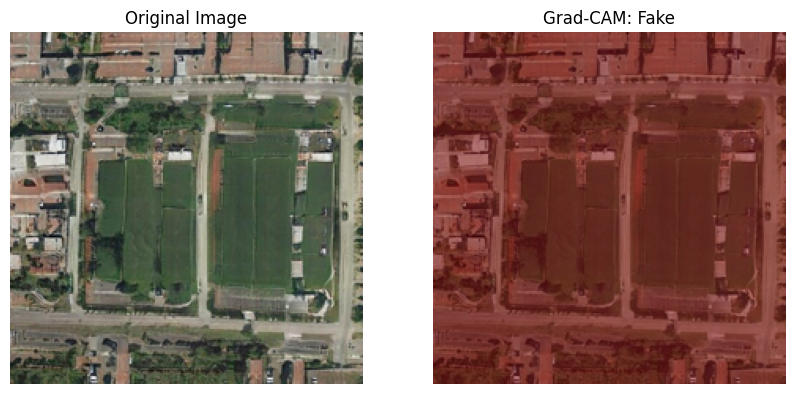

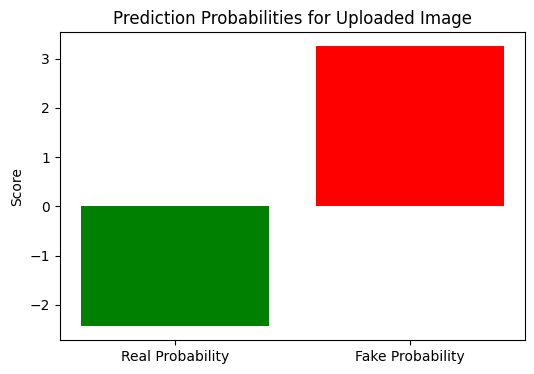

Ideal Real Profile: [0.99287975 0.00712068]
Ideal Fake Profile: [0.00246472 0.9975353 ]


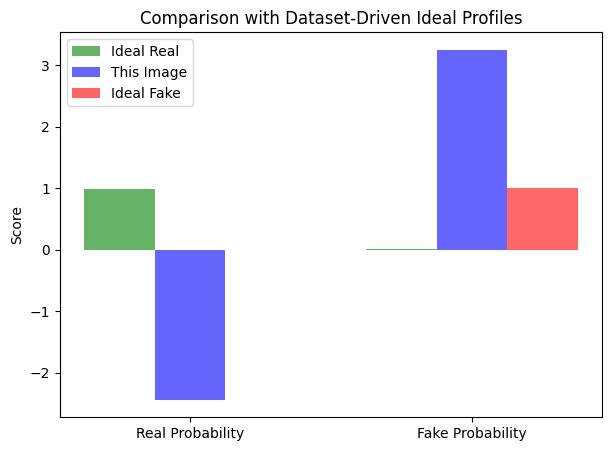


📝 Explanation:
🔎 The model focused on unnatural textures/artifacts (red heatmap).
Top parameter: Fake Probability was high → strong evidence of manipulation.
Comparison with dataset-driven ideal profiles shows how this image deviates from typical Real images.


In [ ]:
# ------------------ IMPORTS ------------------
import torch
import torch.nn as nn
import timm
from torchvision import transforms
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
import cv2
import os

# ------------------ DEVICE ------------------
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print("Using device:", device)

# ------------------ STEP 1: LOAD MODEL ------------------
model = timm.create_model('vit_small_patch16_224', pretrained=False, num_classes=2)

# Load trained weights
state_dict = torch.load("/content/best_vit_small_model.pth", map_location="cpu")
new_state_dict = {k.replace("vit.","") if k.startswith("vit.") else k:v for k,v in state_dict.items()}
model.load_state_dict(new_state_dict, strict=False)

model.to(device)
model.eval()
print("✅ Model loaded successfully with trained vit_small!")

# ------------------ STEP 2: LOAD & PREPROCESS IMAGE ------------------
img_path = "/content/000000048.jpg"  # Change this
img = Image.open(img_path).convert("RGB")

transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize([0.5,0.5,0.5],[0.5,0.5,0.5])
])

input_tensor = transform(img).unsqueeze(0).to(device)
rgb_img = np.array(img.resize((224,224))) / 255.0

# ------------------ STEP 3: PREDICTION ------------------
input_tensor.requires_grad_()
outputs = model(input_tensor)
pred = torch.argmax(outputs, dim=1).item()
classes = ["Real","Fake"]
prediction_label = classes[pred]
print(f"✅ Model Prediction: {prediction_label}")

# ------------------ STEP 4: HOOKS FOR GRAD-CAM ------------------
activations, grads = None, None

def forward_hook(module, input, output):
    global activations
    activations = output

def backward_hook(module, grad_input, grad_output):
    global grads
    grads = grad_output[0]

target_block = model.blocks[-1]
target_block.attn.proj.register_forward_hook(forward_hook)
target_block.attn.proj.register_full_backward_hook(backward_hook)

# ------------------ STEP 5: FORWARD & BACKWARD ------------------
model.zero_grad()
outputs = model(input_tensor)
pred = torch.argmax(outputs, dim=1).item()
outputs[0, pred].backward()

if activations is None or grads is None:
    raise RuntimeError("Hooks did not fire. Check target_layer.")

# ------------------ STEP 6: COMPUTE GRAD-CAM ------------------
patch_activations = activations[:, 1:, :]
patch_grads = grads[:, 1:, :]

weights = patch_grads.mean(dim=2, keepdim=True)
cam = (weights * patch_activations).sum(dim=2)

num_patches = int(cam.shape[1]**0.5)
cam = cam.reshape(num_patches, num_patches).cpu().detach().numpy()

# ------------------ STEP 7: NORMALIZE & SELECT COLORMAP ------------------
if prediction_label == "Fake":
    cam = np.maximum(cam,0)
    colormap = cv2.COLORMAP_JET      # reddish
else:
    cam = np.maximum(cam,0)
    colormap = cv2.COLORMAP_SUMMER   # greenish

cam = cam / cam.max()
cam = cv2.resize(cam, (224,224))

# ------------------ STEP 8: OVERLAY HEATMAP ------------------
heatmap = cv2.applyColorMap(np.uint8(255*cam), colormap)
cam_image = cv2.addWeighted(np.uint8(rgb_img*255), 0.5, heatmap, 0.5, 0)

# ------------------ STEP 9: VISUALIZE RESULTS ------------------
plt.figure(figsize=(10,5))
plt.subplot(1,2,1)
plt.imshow(rgb_img)
plt.title("Original Image")
plt.axis("off")
plt.subplot(1,2,2)
plt.imshow(cam_image)
plt.title(f"Grad-CAM: {prediction_label}")
plt.axis("off")
plt.show()

# ------------------ STEP 10: FEATURE IMPORTANCE (TOP PARAMETERS) ------------------
feature_vector = outputs[0].detach().cpu().numpy()
feature_names = ["Real Probability", "Fake Probability"]

plt.figure(figsize=(6,4))
plt.bar(feature_names, feature_vector, color=["green","red"])
plt.title("Prediction Probabilities for Uploaded Image")
plt.ylabel("Score")
plt.show()

# ------------------ STEP 11: COMPARE WITH IDEAL REAL/FAKE (DATA-DRIVEN) ------------------

# Base folders in your Drive
real_base = '/content/drive/MyDrive/DM-AER-DeepFake-V1-sample/DM-AER-DeepFake-V1-sample/validation/REAL'
fake_base = '/content/drive/MyDrive/DM-AER-DeepFake-V1-sample/DM-AER-DeepFake-V1-sample/validation/FAKE'

def collect_image_paths(base_folder, limit=None):
    """Recursively collect image paths from a base folder."""
    image_paths = []
    for root, _, files in os.walk(base_folder):
        for file in sorted(files):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
            if limit and len(image_paths) >= limit:
                return image_paths
    return image_paths

def compute_ideal_probs(image_paths, model, device, transform):
    probs_list = []
    for path in image_paths:
        img = Image.open(path).convert("RGB")
        input_tensor = transform(img).unsqueeze(0).to(device)
        with torch.no_grad():
            output = model(input_tensor)
            prob = torch.softmax(output, dim=1).cpu().numpy().flatten()
            probs_list.append(prob)
    return np.mean(probs_list, axis=0)

# Collect all images
real_image_paths = collect_image_paths(real_base)
fake_image_paths = collect_image_paths(fake_base)

# Compute dataset-driven ideal profiles
ideal_real = compute_ideal_probs(real_image_paths, model, device, transform)
ideal_fake = compute_ideal_probs(fake_image_paths, model, device, transform)

print("Ideal Real Profile:", ideal_real)
print("Ideal Fake Profile:", ideal_fake)

# ------------------ STEP 11B: PLOT COMPARISON ------------------
x = np.arange(len(feature_names))
width = 0.25

plt.figure(figsize=(7,5))
plt.bar(x - width, ideal_real, width, label="Ideal Real", color="green", alpha=0.6)
plt.bar(x, feature_vector, width, label="This Image", color="blue", alpha=0.6)
plt.bar(x + width, ideal_fake, width, label="Ideal Fake", color="red", alpha=0.6)

plt.xticks(x, feature_names)
plt.ylabel("Score")
plt.title("Comparison with Dataset-Driven Ideal Profiles")
plt.legend()
plt.show()

# ------------------ STEP 12: EXPLANATION ------------------
if prediction_label=="Fake":
    explanation = (
        f"🔎 The model focused on unnatural textures/artifacts (red heatmap).\n"
        f"Top parameter: Fake Probability was high → strong evidence of manipulation.\n"
        f"Comparison with dataset-driven ideal profiles shows how this image deviates from typical Real images."
    )
else:
    explanation = (
        f"✅ The model found consistent natural features (green heatmap).\n"
        f"Top parameter: Real Probability was high → image characteristics align with natural ones.\n"
        f"Comparison with dataset-driven ideal profiles shows this image aligns well with typical Real images."
    )

print("\n📝 Explanation:")
print(explanation)


Number of real images: 1000
Number of fake images: 1005


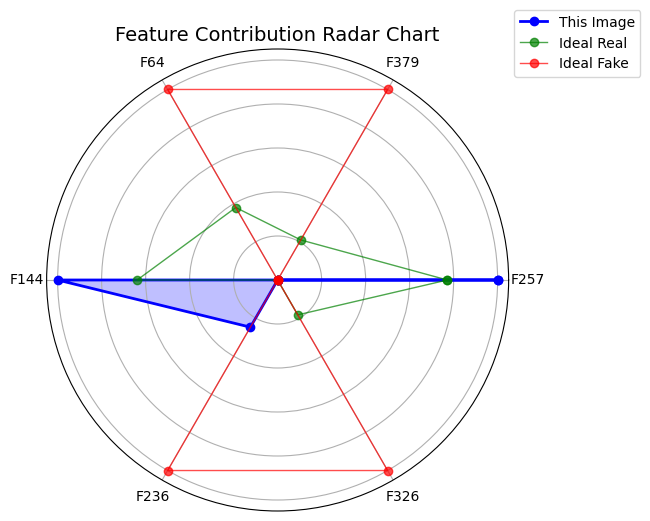

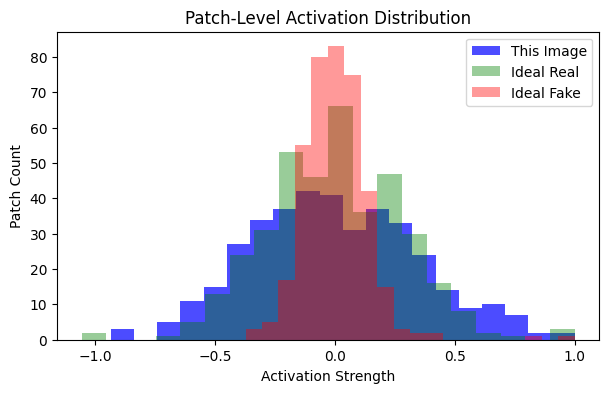



📝 Detailed Image Classification Explanation:

1️⃣ Predicted Class: Real

2️⃣ Radar Chart Analysis:
   - The radar chart shows the top-6 most activated features of the target image (blue).
   - It can be visually seen that the blue line is closer to Ideal Real (green), indicating that the feature activations of the image
     are more consistent with the texture and patterns of a Real image.

3️⃣ Patch-Level Histogram Analysis:
   - The histogram illustrates the distribution of patch activations across the image (blue) compared to Ideal Real (green) and Ideal Fake (red).
   - The image activations aligns more with Ideal Real (green), which supports the Real prediction.
   - Strong alignment with Ideal Fake (red) would indicate unusual artifacts or synthetic patterns,
     whereas alignment with Ideal Real (green) suggests natural consistency.

✅ Conclusion:
   - Both the radar chart and the patch-level histogram consistently show that the image's features
     and patch activations re

In [ ]:
# ------------------ STEP 13 & 14: RADAR CHART AND PATCH-LEVEL HISTOGRAM WITH BOTH IDEAL CLASSES ------------------
import os
import cv2
import numpy as np
import matplotlib.pyplot as plt
from PIL import Image
import torch
from sklearn.preprocessing import MinMaxScaler

# ------------------ FETCH ALL IMAGES ------------------
real_base = '/content/drive/MyDrive/DM-AER-DeepFake-V1-sample/DM-AER-DeepFake-V1-sample/validation/REAL/Million-AED'
fake_base = '/content/drive/MyDrive/DM-AER-DeepFake-V1-sample/DM-AER-DeepFake-V1-sample/validation/FAKE/StyleGAN2-AED-V1-800K'

def collect_image_paths(base_folder):
    image_paths = []
    for root, _, files in os.walk(base_folder):
        for file in sorted(files):
            if file.lower().endswith(('.jpg', '.jpeg', '.png')):
                image_paths.append(os.path.join(root, file))
    return image_paths

real_image_paths = collect_image_paths(real_base)
fake_image_paths = collect_image_paths(fake_base)

print(f"Number of real images: {len(real_image_paths)}")
print(f"Number of fake images: {len(fake_image_paths)}")

# ------------------ LOAD IMAGE ARRAY ------------------
def load_image_array(path, resize_to=(128,128)):
    img = cv2.imread(path)
    if img is None:
        raise ValueError(f"Failed to load image: {path}")
    img = cv2.resize(img, resize_to)
    img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
    return img

# ------------------ CLS EMBEDDING FUNCTION ------------------
def get_cls_embedding(img_array, model, device, transform):
    img = Image.fromarray(img_array).convert("RGB")
    input_tensor = transform(img).unsqueeze(0).to(device)
    with torch.no_grad():
        vit_features = model.forward_features(input_tensor)
        cls_emb = vit_features[:, 0, :].cpu().numpy().flatten()
    return cls_emb

# ------------------ COMPUTE DATASET EMBEDDINGS ------------------
real_emb_list = [get_cls_embedding(load_image_array(p), model, device, transform) for p in real_image_paths]
fake_emb_list = [get_cls_embedding(load_image_array(p), model, device, transform) for p in fake_image_paths]

ideal_real_emb = np.mean(np.stack(real_emb_list), axis=0)
ideal_fake_emb = np.mean(np.stack(fake_emb_list), axis=0)

# ------------------ TARGET IMAGE ------------------
target_img = load_image_array(real_image_paths[0])  # example target
cls_embedding = get_cls_embedding(target_img, model, device, transform)

# ------------------ TOP-N FEATURES BY IMPORTANCE ------------------
# Importance = difference from opposite class
feature_importance = np.abs(cls_embedding - ideal_fake_emb)  # measure against Fake
top_n = 6
top_indices = np.argsort(feature_importance)[-top_n:]

selected_features = cls_embedding[top_indices]
ideal_real_sel = ideal_real_emb[top_indices]
ideal_fake_sel = ideal_fake_emb[top_indices]

# ------------------ NORMALIZE ------------------
scaler = MinMaxScaler()
all_embs = np.vstack([
    selected_features.reshape(1,-1),
    ideal_real_sel.reshape(1,-1),
    ideal_fake_sel.reshape(1,-1)
])
scaler.fit(all_embs)

selected_norm = scaler.transform(selected_features.reshape(1,-1)).flatten()
ideal_real_norm = scaler.transform(ideal_real_sel.reshape(1,-1)).flatten()
ideal_fake_norm = scaler.transform(ideal_fake_sel.reshape(1,-1)).flatten()

# ------------------ RADAR CHART ------------------
angles = np.linspace(0, 2*np.pi, top_n, endpoint=False).tolist()
selected_plot = np.concatenate((selected_norm,[selected_norm[0]]))
ideal_real_plot = np.concatenate((ideal_real_norm,[ideal_real_norm[0]]))
ideal_fake_plot = np.concatenate((ideal_fake_norm,[ideal_fake_norm[0]]))
angles += angles[:1]

fig = plt.figure(figsize=(6,6))
ax = fig.add_subplot(111, polar=True)
ax.plot(angles, selected_plot, 'o-', linewidth=2, label="This Image", color="blue")
ax.fill(angles, selected_plot, color="blue", alpha=0.25)
ax.plot(angles, ideal_real_plot, 'o-', linewidth=1, label="Ideal Real", color="green", alpha=0.7)
ax.plot(angles, ideal_fake_plot, 'o-', linewidth=1, label="Ideal Fake", color="red", alpha=0.7)

ax.set_xticks(angles[:-1])
ax.set_xticklabels([f"F{i}" for i in top_indices])
ax.set_yticklabels([])
ax.set_title("Feature Contribution Radar Chart", size=14)
ax.legend(loc="upper right", bbox_to_anchor=(1.3, 1.1))
plt.show()

print()

# ------------------ PATCH-LEVEL HISTOGRAM ------------------
cam = cls_embedding
cam_norm = cam / cam.max() if cam.max() > 0 else cam
ideal_real_norm_full = ideal_real_emb / ideal_real_emb.max()
ideal_fake_norm_full = ideal_fake_emb / ideal_fake_emb.max()

plt.figure(figsize=(7,4))
plt.hist(cam_norm.flatten(), bins=20, alpha=0.7, label="This Image", color="blue")
plt.hist(ideal_real_norm_full.flatten(), bins=20, alpha=0.4, label="Ideal Real", color="green")
plt.hist(ideal_fake_norm_full.flatten(), bins=20, alpha=0.4, label="Ideal Fake", color="red")
plt.title("Patch-Level Activation Distribution")
plt.xlabel("Activation Strength")
plt.ylabel("Patch Count")
plt.legend()
plt.show()

print()

# ------------------ ENHANCED EXPLANATION ------------------
from sklearn.metrics.pairwise import cosine_similarity

# Compute similarity to both ideal embeddings
sim_to_real = cosine_similarity(cls_embedding.reshape(1,-1), ideal_real_emb.reshape(1,-1))[0][0]
sim_to_fake = cosine_similarity(cls_embedding.reshape(1,-1), ideal_fake_emb.reshape(1,-1))[0][0]

# Determine predicted class based on higher similarity
predicted_class = "Real" if sim_to_real > sim_to_fake else "Fake"

# Radar chart closeness
radar_closeness = "closer to Ideal Real (green)" if sim_to_real > sim_to_fake else "closer to Ideal Fake (red)"

# Patch histogram closeness
image_mean = cam_norm.mean()
real_mean = ideal_real_norm_full.mean()
fake_mean = ideal_fake_norm_full.mean()
hist_closeness = "aligns more with Ideal Real (green)" if abs(image_mean - real_mean) < abs(image_mean - fake_mean) else "aligns more with Ideal Fake (red)"

# Enhanced explanation
enhanced_explanation = f"""
📝 Detailed Image Classification Explanation:

1️⃣ Predicted Class: {predicted_class}

2️⃣ Radar Chart Analysis:
   - The radar chart shows the top-{top_n} most activated features of the target image (blue).
   - It can be visually seen that the blue line is {radar_closeness}, indicating that the feature activations of the image
     are more consistent with the texture and patterns of a {predicted_class} image.

3️⃣ Patch-Level Histogram Analysis:
   - The histogram illustrates the distribution of patch activations across the image (blue) compared to Ideal Real (green) and Ideal Fake (red).
   - The image activations {hist_closeness}, which supports the {predicted_class} prediction.
   - Strong alignment with Ideal Fake (red) would indicate unusual artifacts or synthetic patterns,
     whereas alignment with Ideal Real (green) suggests natural consistency.

✅ Conclusion:
   - Both the radar chart and the patch-level histogram consistently show that the image's features
     and patch activations resemble a {predicted_class} image.
   - Therefore, the model predicts this image as **{predicted_class}**, supported by clear visual evidence from the graphs.
"""

print(enhanced_explanation)



**Real Part Reconstruction if the image is fake**

Using device: cuda
Loading Stable Diffusion Img2Img pipeline. This may take a while...


Loading pipeline components...:   0%|          | 0/7 [00:00<?, ?it/s]

Pipeline loaded successfully.
Running img2img... (this may take a minute or two depending on steps & device)


  0%|          | 0/16 [00:00<?, ?it/s]

Refined image saved to: sd_refined_result.png


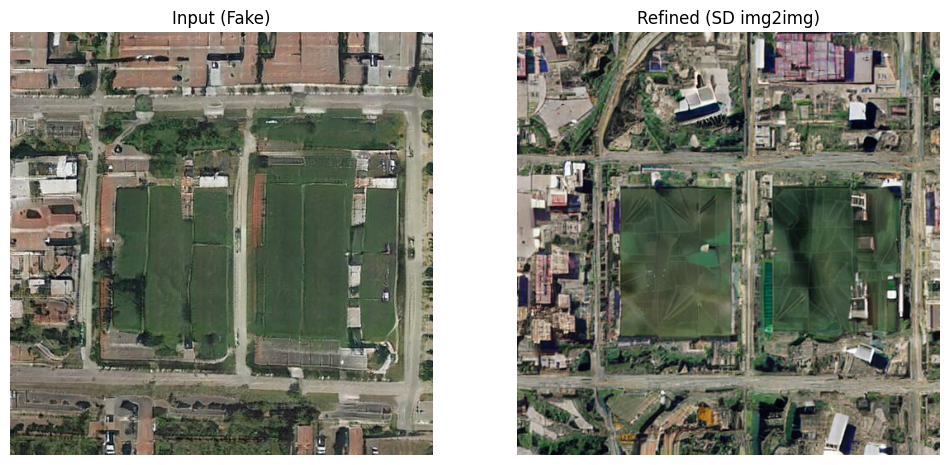

PSNR: 14.44 | SSIM: 0.2024

Prompt used:
photorealistic high-resolution satellite image, realistic textures, natural colors
strength=0.55, guidance_scale=7.5, steps=30


In [ ]:
# ---------------------------
# Full Stable-Diffusion Img2Img Refinement Pipeline
# (uses SD U-Net + VAE + scheduler correctly)
# ---------------------------

# Requirements:
# pip install diffusers[torch] transformers accelerate safetensors
# (Run once in your environment if not already installed)

import os
import torch
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
from diffusers import StableDiffusionImg2ImgPipeline
from torchvision import transforms as T
from skimage.metrics import peak_signal_noise_ratio as psnr, structural_similarity as ssim

# ---------------------------
# USER PARAMETERS — change these
# ---------------------------
img_path = "/content/000000048.jpg"   # <-- path to the fake image you want to refine
out_path = "sd_refined_result.png"                       # <-- where to save refined image
prompt = "photorealistic high-resolution satellite image, realistic textures, natural colors"  # guiding prompt
strength = 0.55        # 0.0 (keep input) .. 1.0 (fully rewrite) — lower = smaller changes
guidance_scale = 7.5   # classifier-free guidance scale (higher = stronger prompt influence)
num_inference_steps = 30

# Optional: if you need to pass a Hugging Face token (if model repo requires it)
# set HF_TOKEN as an environment variable or paste it here (not recommended to hardcode in notebooks)
hf_token = os.getenv("HF_TOKEN")  # or set "hf_token = 'your_token_here'"

# ---------------------------
# Device
# ---------------------------
device = "cuda" if torch.cuda.is_available() else "cpu"
print("Using device:", device)

# ---------------------------
# Load the Stable Diffusion Img2Img pipeline
# ---------------------------
model_id = "runwayml/stable-diffusion-v1-5"

print("Loading Stable Diffusion Img2Img pipeline. This may take a while...")
pipe_kwargs = {"torch_dtype": torch.float16} if device == "cuda" else {}
if hf_token:
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, use_auth_token=hf_token, **pipe_kwargs)
else:
    pipe = StableDiffusionImg2ImgPipeline.from_pretrained(model_id, **pipe_kwargs)

pipe = pipe.to(device)

# ✅ FIX: disable safety checker properly
def dummy_safety_checker(images, clip_input):
    return images, [False] * len(images)

pipe.safety_checker = dummy_safety_checker

print("Pipeline loaded successfully.")


# ---------------------------
# Load image & prepare
# ---------------------------
init_image = Image.open(img_path).convert("RGB")
# The pipeline will internally resize the image to multiples of 8 -- but it's fine to keep 512x512
init_image = init_image.resize((512, 512))

# Convert to pipeline expected format (PIL image is fine)
# If you want deterministic outputs, set generator
generator = torch.Generator(device=device).manual_seed(42)

# ---------------------------
# Run img2img (this runs the SD U-Net with scheduler properly)
# ---------------------------
print("Running img2img... (this may take a minute or two depending on steps & device)")
result = pipe(
    prompt=prompt,
    image=init_image,
    strength=strength,
    guidance_scale=guidance_scale,
    num_inference_steps=num_inference_steps,
    generator=generator
)
# result.images is a list of PIL images (first element is our refined image)
refined_pil = result.images[0]

# Save refined
refined_pil.save(out_path)
print("Refined image saved to:", out_path)

# ---------------------------
# Visualize input vs refined
# ---------------------------
orig_arr = np.array(init_image).astype(np.float32) / 255.0
refined_arr = np.array(refined_pil).astype(np.float32) / 255.0

plt.figure(figsize=(12,6))
plt.subplot(1,2,1)
plt.imshow(orig_arr)
plt.title("Input (Fake)")
plt.axis("off")

plt.subplot(1,2,2)
plt.imshow(refined_arr)
plt.title("Refined (SD img2img)")
plt.axis("off")
plt.show()

# ---------------------------
# PSNR & SSIM evaluation
# If you have a ground-truth real counterpart, set `real_path` to compute against it.
# Otherwise, this compares refined vs input (so PSNR/SSIM measure change, not 'truth')
# ---------------------------
# If you have true real counterpart:
# real_path = "/path/to/real_counterpart.jpg"
# real_img = np.array(Image.open(real_path).convert("RGB").resize((512,512))).astype(np.float32)/255.0
# else compare with input:
real_img = orig_arr

psnr_val = psnr(real_img, refined_arr, data_range=1.0)
ssim_val = ssim(real_img, refined_arr, channel_axis=2, data_range=1.0)
print(f"PSNR: {psnr_val:.2f} | SSIM: {ssim_val:.4f}")

# ---------------------------
# Optional: show prompt & parameters used
# ---------------------------
print(f"\nPrompt used:\n{prompt}\nstrength={strength}, guidance_scale={guidance_scale}, steps={num_inference_steps}")


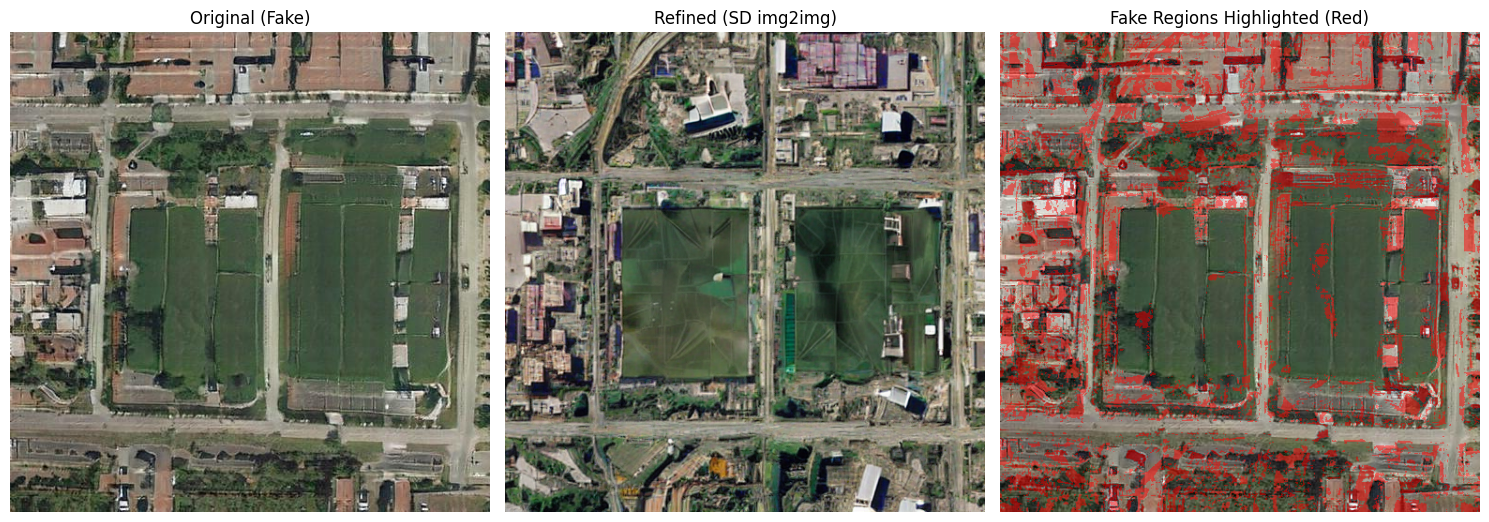

In [ ]:
# ---------------------------
# Highlight Fake Patches in Red
# ---------------------------
import cv2

# Convert both images to LAB color space (captures perceptual color differences)
fake_lab = cv2.cvtColor((orig_arr * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)
refined_lab = cv2.cvtColor((refined_arr * 255).astype(np.uint8), cv2.COLOR_RGB2LAB)

# Compute absolute difference
diff = cv2.absdiff(fake_lab, refined_lab)
diff_gray = np.mean(diff, axis=2).astype(np.float32)

# Normalize to [0,1]
diff_norm = (diff_gray - diff_gray.min()) / (diff_gray.max() - diff_gray.min() + 1e-8)

# Threshold for fake regions
threshold = 0.25  # tweak between 0.2–0.4 for sensitivity
mask = (diff_norm > threshold).astype(np.float32)

# Create a red overlay (same size as image)
red_overlay = np.zeros_like(orig_arr)
red_overlay[..., 0] = 1.0  # Red channel full intensity

# Blend the red overlay where mask is True
alpha = 0.5  # transparency factor (0 = none, 1 = fully red)
highlighted = orig_arr.copy()
highlighted = (1 - alpha * mask[..., None]) * highlighted + (alpha * mask[..., None]) * red_overlay

# Display results
plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(orig_arr)
plt.title("Original (Fake)")
plt.axis("off")

plt.subplot(1,3,2)
plt.imshow(refined_arr)
plt.title("Refined (SD img2img)")
plt.axis("off")

plt.subplot(1,3,3)
plt.imshow(highlighted)
plt.title("Fake Regions Highlighted (Red)")
plt.axis("off")

plt.tight_layout()
plt.show()


**Visualization**

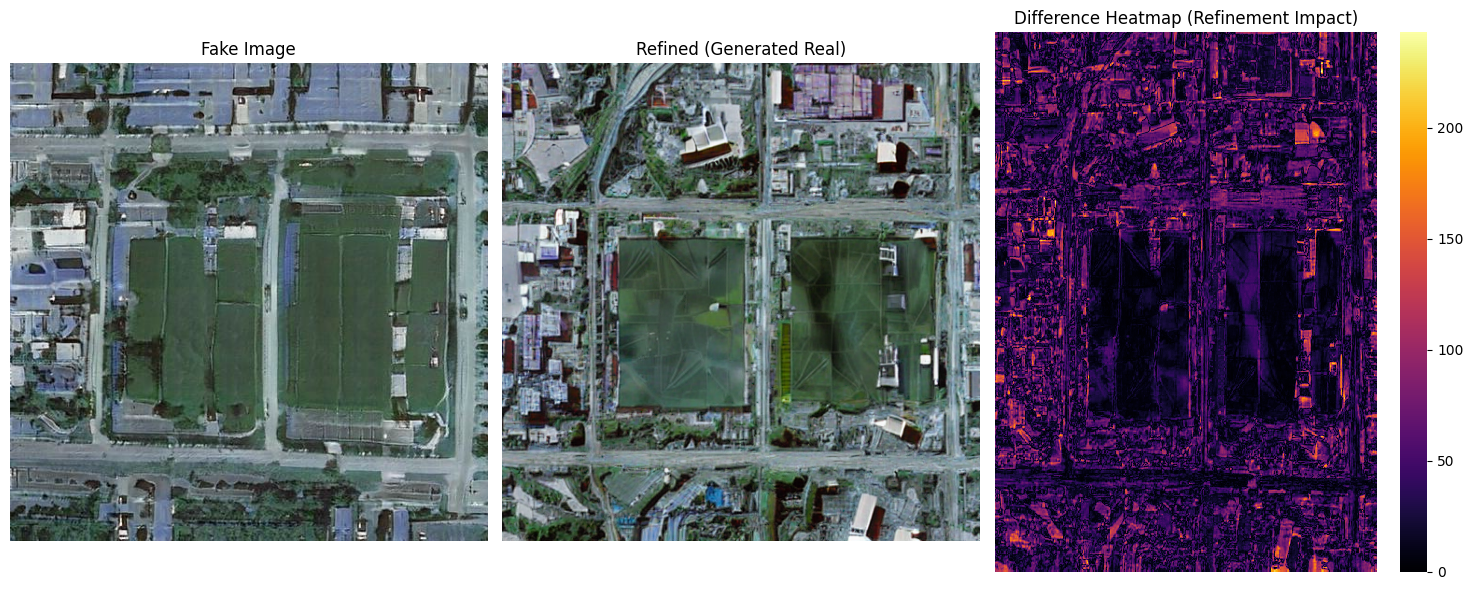

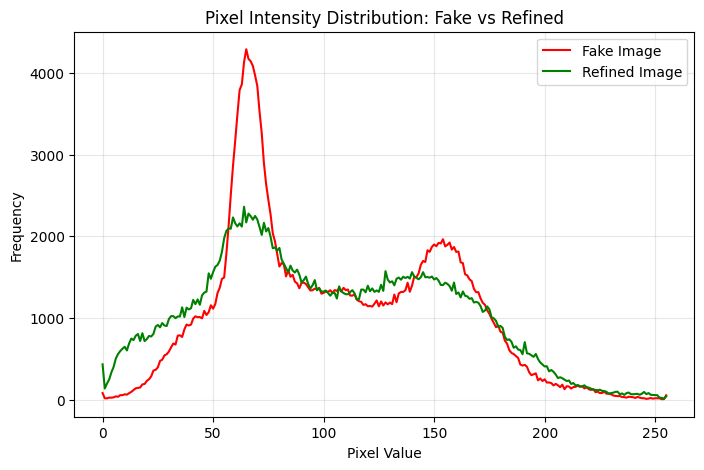

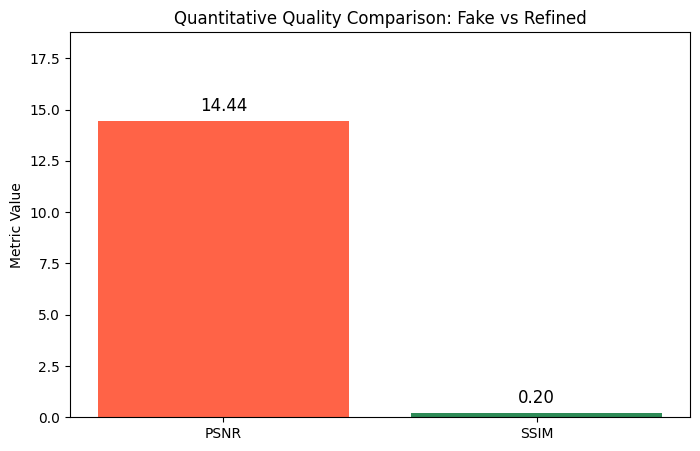

In [ ]:
import cv2
import seaborn as sns

# Ensure both arrays are 0–1 float32
fake = (orig_arr * 255).astype(np.uint8)
refined = (refined_arr * 255).astype(np.uint8)

# ---------------------------
# 1️⃣ Difference Visualization (RGB + Heatmap)
# ---------------------------
diff = cv2.absdiff(fake, refined)
diff_gray = np.mean(diff, axis=2)

plt.figure(figsize=(15,6))
plt.subplot(1,3,1)
plt.imshow(cv2.cvtColor(fake, cv2.COLOR_BGR2RGB))
plt.title("Fake Image")
plt.axis('off')

plt.subplot(1,3,2)
plt.imshow(cv2.cvtColor(refined, cv2.COLOR_BGR2RGB))
plt.title("Refined (Generated Real)")
plt.axis('off')

plt.subplot(1,3,3)
sns.heatmap(diff_gray, cmap='inferno', cbar=True)
plt.title("Difference Heatmap (Refinement Impact)")
plt.axis('off')
plt.tight_layout()
plt.show()

# ---------------------------
# 2️⃣ Histogram Comparison
# ---------------------------
fake_hist = cv2.calcHist([fake],[0],None,[256],[0,256])
refined_hist = cv2.calcHist([refined],[0],None,[256],[0,256])

plt.figure(figsize=(8,5))
plt.plot(fake_hist, color='red', label='Fake Image')
plt.plot(refined_hist, color='green', label='Refined Image')
plt.title("Pixel Intensity Distribution: Fake vs Refined")
plt.xlabel("Pixel Value")
plt.ylabel("Frequency")
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# ---------------------------
# 3️⃣ Metric Highlight Graph
# ---------------------------
metrics = ['PSNR', 'SSIM']
values = [psnr_val, ssim_val]

plt.figure(figsize=(8,5))
bars = plt.bar(metrics, values, color=['tomato','seagreen'])
for i, val in enumerate(values):
    plt.text(i, val + 0.5, f"{val:.2f}", ha='center', fontsize=12)
plt.title("Quantitative Quality Comparison: Fake vs Refined")
plt.ylabel("Metric Value")
plt.ylim(0, max(values)*1.3)
plt.show()
